In [1]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate
from keras.callbacks import TensorBoard

import h5py

Using TensorFlow backend.


In [2]:
# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(64, return_sequences=False)(inputs_list[i]) )
        
    output = concatenate(layers) 
    output = Dense(1, activation='linear', name='weighted_average_output')(output)
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model    
        
data_length = 10
label_length = 10

In [3]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]

# lag price 
df['Price_lagged'] = df['Close'].shift(1)

df = df.dropna()

df['Volume_BTC'] = df['Volume_(BTC)']
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']

cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']

# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)

# Min-Max Scale 

scalers = {}
datas = [] 

df_scaled = pd.DataFrame(columns=cols)

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )  #:, np.newaxis
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = data[0]
    

# for data in datas:
#     data_scaled = np.concatenate((data_scaled, data), axis=1)

# scaler = MinMaxScaler() 
# data_scaled = scaler.fit_transform(data_array)
# df_scaled = pd.DataFrame(data_scaled, columns=cols)

display(df_scaled.head())

# results in 0s ?? 
# scaler_y = MinMaxScaler()
# scaler_y.fit_transform( [np.float32( np.diff(np.log(df['Close'] )  , axis=0)  )])




# cols = ['Timestamp','Volume_BTC', 'Bitcoin_Adj', 'Close']

# for col in cols:
#     df[col] = scaler.fit_transform([df[col].values])

# X = df[['Timestamp', 'Volume_BTC', 'Bitcoin_Adj']].values
# Y = df['Close'].values


# X_train, X_test = X[1:train_size], X[train_size:len(X)]
# Y_train, Y_test = Y[1:train_size], Y[train_size:len(X)]
# print('Observations: %d' % (len(X)))
# print('Training Observations: %d' % (len(X_train)))
# print('Testing Observations: %d' % (len(Y_test)))


C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged
0,0.272890,0.453625,0.566575,0.582900
1,0.776791,0.471970,0.484557,0.566575
2,0.463316,0.439996,0.538331,0.484557
3,0.725079,0.529463,0.520715,0.538331
4,0.210661,0.416611,0.566098,0.520715


In [6]:
# split and reshape data to feed into RNN

# X_timestamp = df_scaled['Timestamp'].values
X_volume = df_scaled['Volume_BTC'].values
X_trends = df_scaled['Bitcoin_Adj'].values
X_lagged_price = df_scaled['Price_lagged'].values

Y_price = df_scaled['Close'].values 

train_size = int(len(X_volume) * 0.85)
train_size = int(train_size/data_length) * data_length

test_size_index = int(len(X_volume)/data_length)*data_length

X_train_volume = []
X_test_volume = [] 
X_train_trends = []
X_test_trends = []
X_train_lagged_price = []
X_test_lagged_price = []
Y_train_price = [] 
Y_test_price = [] 

for i in range(train_size-data_length):
    vol_temp = []
    trends_temp = []
    price_temp = []
    for j in range(data_length):
        vol_temp.append(X_volume[i+j])
        trends_temp.append(X_trends[i+j])
        price_temp.append(X_lagged_price[i+j])
    X_train_volume.append(vol_temp)
    X_train_trends.append(trends_temp)
    X_train_lagged_price.append(price_temp)
    
    Y_train_price.append(Y_price[i+data_length])

for i in range(test_size_index-train_size-data_length):
    vol_temp = []
    trends_temp = [] 
    price_temp = [] 
    for j in range(data_length):
        vol_temp.append(X_volume[train_size+i+j])
        trends_temp.append(X_trends[train_size+i+j])
        price_temp.append(X_lagged_price[train_size+i+j])
    X_test_volume.append(vol_temp)
    X_test_trends.append(trends_temp)
    X_test_lagged_price.append(price_temp)
    
    Y_test_price.append(Y_price[train_size+i+data_length])
    
X_train_volume = np.array(X_train_volume)
X_test_volume =  np.array(X_test_volume)
X_train_trends = np.array(X_train_trends)
X_test_trends = np.array(X_test_trends)
X_train_lagged_price = np.array(X_train_lagged_price)
X_test_lagged_price = np.array(X_test_lagged_price)

Y_train_price =  np.array(Y_train_price)
Y_test_price = np.array(Y_test_price)
    
# reshape
X_train_volume = np.reshape(X_train_volume, (X_train_volume.shape[0],data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (X_train_trends.shape[0],data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (X_train_lagged_price.shape[0], data_length, 1))

X_test_volume = np.reshape(X_test_volume, (X_test_volume.shape[0],data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (X_test_trends.shape[0],data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (X_test_lagged_price.shape[0],data_length,1))

# #X_timestamp = df_scaled['Timestamp'].values
# X_volume = df_scaled['Volume_BTC'].values
# X_trends = df_scaled['Bitcoin_Adj'].values
# X_lagged_price = df_scaled['Price_lagged'].values

# Y_price = df_scaled['Close'].values

# train_size = int(len(X_volume) * 0.85)
# train_size = int(train_size/10) * 10 

# test_size_index = int(len(X_volume)/10)*10

# #X_train_timestamp, X_test_timestamp = X_timestamp[:train_size], X_timestamp[train_size:test_size_index ]
# X_train_volume, X_test_volume = X_volume[:train_size], X_volume[train_size:test_size_index ]
# X_train_trends, X_test_trends = X_trends[:train_size], X_trends[train_size:test_size_index ]
# X_train_lagged_price, X_test_lagged_price = X_lagged_price[:train_size], X_lagged_price[train_size:test_size_index ]

# Y_train_price, Y_test_price = Y_price[:train_size], Y_price[train_size:test_size_index ]


# # X.shape is (samples, timesteps, dimension) 
# # timestemps is 15, samples is just however many nobs there are (but it doesn't matter, so it should be None)



# # X_train_timestamp = np.reshape(X_train_timestamp, (int(X_train_timestamp.shape[0]/data_length),data_length,1) ) 
# X_train_volume = np.reshape(X_train_volume, (int(X_train_volume.shape[0]/data_length),data_length,1) ) 
# X_train_trends = np.reshape(X_train_trends, (int(X_train_trends.shape[0]/data_length),data_length,1) ) 
# X_train_lagged_price = np.reshape(X_train_lagged_price, (int(X_train_lagged_price.shape[0]/data_length), data_length, 1))

# # X_test_timestamp = np.reshape(X_test_timestamp, (int(X_test_timestamp.shape[0]/data_length),data_length,1) ) 
# X_test_volume = np.reshape(X_test_volume, (int(X_test_volume.shape[0]/data_length),data_length,1) ) 
# X_test_trends = np.reshape(X_test_trends, (int(X_test_trends.shape[0]/data_length),data_length,1) )  
# X_test_lagged_price = np.reshape(X_test_lagged_price, (int(X_test_lagged_price.shape[0]/data_length),data_length,1))


# # Don't need the 1 for the third dimension for Y's??


# Y_train_price = np.reshape(Y_train_price, (int(Y_train_price.shape[0]/data_length),  data_length) ) 
# Y_test_price = np.reshape(Y_test_price, (int(Y_test_price.shape[0]/data_length),  data_length) ) 

In [7]:
features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']

rnn = build_model(features, 10) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        #X_train_timestamp,
        X_train_volume,
        X_train_trends,
        X_train_lagged_price
    ],
    [
        Y_train_price
    ]
    ,
#     validation_data=(
#         [
#             #X_test_timestamp,
#             X_test_volume,
#             X_test_trends,
#             X_test_lagged_price
#         ],
#         [
#             Y_test_price
#         ]),
    epochs=10,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)


Epoch 1/10
23850/23850 [==============================] - 19s - loss: 0.0027    
Epoch 2/10
23850/23850 [==============================] - 18s - loss: 0.0011    
Epoch 3/10
23850/23850 [==============================] - 19s - loss: 0.0010    
Epoch 4/10
23850/23850 [==============================] - 18s - loss: 9.7302e-04    
Epoch 5/10
23850/23850 [==============================] - 19s - loss: 9.4350e-04    
Epoch 6/10
23850/23850 [==============================] - 18s - loss: 9.2734e-04    
Epoch 7/10
23850/23850 [==============================] - 19s - loss: 9.0788e-04    
Epoch 8/10
23850/23850 [==============================] - 20s - loss: 8.9698e-04    
Epoch 9/10
23850/23850 [==============================] - 20s - loss: 8.9683e-04    
Epoch 10/10
23850/23850 [==============================] - 20s - loss: 8.8307e-04    


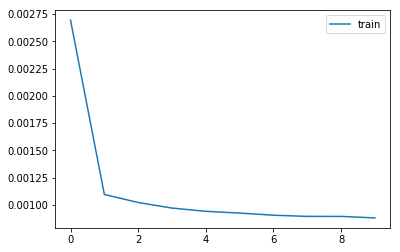

In [8]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [9]:
score = rnn.evaluate(
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    [
        Y_test_price
    ])


display(score)

4096/4200 [============================>.] - ETA: 0s

0.002892147045460574

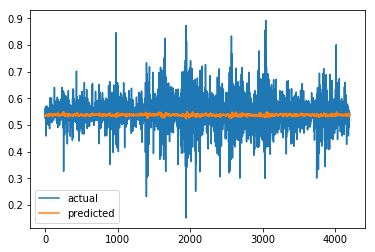

array([[ 0.53551531],
       [ 0.53586584],
       [ 0.53462732],
       ..., 
       [ 0.5334354 ],
       [ 0.53383398],
       [ 0.53565121]], dtype=float32)

array([[ 0.53551531],
       [ 0.53586584],
       [ 0.53462732],
       ..., 
       [ 0.5334354 ],
       [ 0.53383398],
       [ 0.53565121]], dtype=float32)

array([[-0.00253363],
       [-0.00243802],
       [-0.00277584],
       ..., 
       [-0.00310094],
       [-0.00299223],
       [-0.00249657]], dtype=float32)

'yhat'

array([  9.97469544e-01,   9.95040655e-01,   9.92282450e-01, ...,
         2.28483288e-04,   2.27800541e-04,   2.27232493e-04], dtype=float32)

array([ 1.00419134,  0.99829927,  0.9982011 , ...,  1.85037644,
        1.8481438 ,  1.84455514])

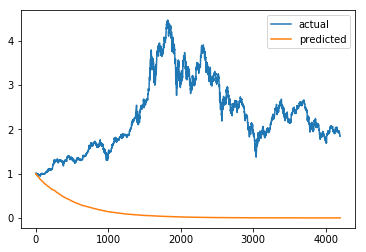

Test RMSE: 2.366


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt 

yhat = rnn.predict( 
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    verbose=0
)

plt.plot(Y_test_price, label='actual')
plt.plot(yhat, label='predicted')
plt.legend()
plt.show();


# invert scaling 
display(yhat)
yhat = yhat.reshape((test_size_index - train_size-data_length, 1 ))# it forecasts the next 10 hours, so just reshape to 1D 
display(yhat)
yhat = scalers['Close'].inverse_transform(yhat)  
display(yhat)
yhat = np.exp(np.cumsum(yhat)) # undo log difference to get original 
display('yhat', yhat)

Y_test_price = Y_test_price.reshape((test_size_index - train_size-data_length, 1 ))
Y_test_price_inv = scalers['Close'].inverse_transform(Y_test_price) 
Y_test_price_inv = np.exp(np.cumsum( Y_test_price_inv   ))  
display(Y_test_price_inv)

#Y_test_price_inv = np.exp(np.cumsum(   np.concatenate( ( df['Close'].iloc[0]  ,Y_test_price_inv )  )   ))  # np.concatenate(([x[0]], x_diff))

plt.plot(Y_test_price_inv, label='actual')
plt.plot(yhat, label='predicted')
plt.legend()
plt.show();

rmse = sqrt(mean_squared_error(Y_test_price_inv[1:], yhat[1:]))
print('Test RMSE: %.3f' % rmse)






In [28]:
# serialize model to JSON
model_json = rnn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
rnn.save_weights("model.h5")


In [ ]:
# Probably need to change up x and y to frame it as a supervising problem -> look online to that one article
# also scale it from 0 to 1 
# remove seasonality 
# Change timestamp into some categorial input, not just a timestamp 

# look into if min-max scaling actually worked properly 

# Finally min-max scaled correctly so figure out how to unscale it (invert and undo log difference)